#### CIE4604 Simulation and Visualization
# Assignment 2 - GNSS-Reflectometry simulation

GPS and other GNSS satellite signals are reflected by the Earth’s oceans. A GNSS-R(eflectrometry) receiver on board a satellite in a low Earth orbit (LEO) is able to receive both the **direct** signal from a GNSS satellite, as well as the signal **reflected** by the surface of the Earth. This will provide very useful information on the Sea state and level in particular

![Remote Sensing geometry of GNSS-R (From: Jales, 2012](Jales2012.png)

For this assignment you are given the task to simulate a GNSS-R(eflectometry) experiment on board the International Space Station (ISS). 

All the Python scripts can be found in `CIE4604-M2-python` that you can download from Brightspace. For the assignment you need the following modules
- `tleplot.py`
- `crsutil.py`
- `specularpoint.py`

You will also need to have `simplekml` installed (See exercise 6). 

The `CIE4604-M2-python` download comes with 8 exercises in Jupyter notebooks. We suggest that you study the Jupyter notebooks first and do the exercises. These already contain a lot of useful material for the assignment, some of which can be re-purposed for the assignment. An other option is to do this assignment in parallel with the exercises.

## Description of the GNSS-R experiment on board the ISS

For the experiment a GNSS-R receiver will be installed on board the ISS. A GNSS-R receiver is able to

1.	Receive the direct signal from Global Navigation Satellite Systems (GNSS), such as the US GPS, Russian GLONASS, European GALILEO and Chinese BEIDOU satellites,
2.	Receive reflected GNSS signals from the Earth surface.

The path delay difference between direct and reflected signal is a measure for the Sea-surface height. However, by recording the full reflected wave form also other parameters about the sea state, such as wave-height and direction, can be retrieved.

The GNSS-R receiver on board the ISS uses two antenna’s, one **upward looking** standard **omnidirectional** antenna for the **direct** signals, and a specially designed **downward looking** antenna for the **reflected** signals. The opening angle of downward antenna (field of view) is not yet decided: the final value will depend on the outcome of the simulation, and will be a trade-off between received power and coverage.

## Breakdown in sub-tasks

The first step of any task is to break it down in more manageable sub-tasks. Normally this is something that you have to do yourself, but here, for this assignment, we will give you the task breakdown. The sub-tasks you have to perform are:

1. Simulate and visualize the ISS orbit trajectory
2. Simulate and visualize the GPS satellite orbits
3. Simulate and visualize GNSS signals from the upward looking omnidirectional antenna on the ISS (direct signals)
4. Simulate and visualize GNSS signals from the down looking antenna on the ISS (reflected signals)

More details on each sub-task can be found in the following cells.

## 1. Simulate and visualize the ISS orbit trajectory


In [1]:
import matplotlib.pyplot as plt
import tleplot as tle
import crsutil as crs
import specularpoint as sp
import numpy as np
from scipy.io import loadmat


In [2]:
def scircle1(lat0,lon0,theta):
    
    slat0 = np.sin(np.deg2rad(lat0))
    clat0 = np.cos(np.deg2rad(lat0))

    stheta = np.sin(np.deg2rad(theta))
    ctheta= np.cos(np.deg2rad(theta))
    
    alpha = np.deg2rad( np.arange(0,365,10) )
    
    lat = np.arctan2( slat0*ctheta + clat0*stheta*np.cos(alpha) ,
         np.sqrt( (clat0*ctheta - slat0*stheta*np.cos(alpha))**2 + (stheta *np.sin(alpha))**2 ))
    dlon = np.arctan2( stheta * np.sin(alpha) , clat0*ctheta - slat0*stheta*np.cos(alpha) )

    lat = np.rad2deg(lat)
    lon = lon0 + np.rad2deg(dlon)

    return lat, lon

Simulate and visualize the orbit trajectory of the International Space Station ISS. You may use Two-Line Elements (TLE) for ISS (Zarya) that you can find on Celestrak. The questions need to be answered in this sub-task:

a.	What are the main limitations of using GNSS-R from the ISS for the spatial and temporal coverage?
Hint: To answer this question you have to plot the ISS ground tracks (sub-satellite tracks), for which you may use `pltgroundtracks` from the `tleplot` Python module. 


In [3]:
# get the most recent 
tle.tleget('stations')
tleERS = tle.tleread('stations.txt',verbose=0)

Saving TLE set to default name
TLEGET: Downloaded stations.txt from http://celestrak.com/NORAD/elements/
Saved TLE to stations.txt


In [60]:
isat,name = tle.tlefind(tleERS,'ISS (ZA')
numdays = 20
t = tle.tledatenum(['2021-11-25 0:00:00', numdays*24*60 ,0.5])
def calculate_iss_ecef(t):
    """ 
    accepts a time array 
    
    returns a tuple of the position and velocity arrays for the ISS Zayra spacecraft
    """
    iss_xvals,iss_vvals = tle.tle2vec(tleERS,t,'ISS (ZA')
    iss_xvalse,iss_vvalse = crs.eci2ecef(t,xsat=iss_xvals,vsat=iss_vvals)
    return iss_xvalse,iss_vvalse

iss_xvalse,iss_vvalse = calculate_iss_ecef(t)


plt.figure(figsize=(20,10))
coast = loadmat('coast.mat')

# using code from the Tleplot

lsat = np.arctan2(iss_xvalse[:,1], iss_xvalse[:,0]) * 180 / np.pi
dsat = np.arctan(iss_xvalse[:,2] / np.sqrt(iss_xvalse[:,1]**2 + iss_xvalse[:,0]**2) )  * 180 / np.pi

# implement masking as in TLEplot function 
lsatmask = np.ma.array(lsat)
dsatmask = np.ma.array(dsat)
lsatmask[np.hstack([False,np.abs(np.diff(lsat)) > 180])] = np.ma.masked 
dsatmask[np.hstack([False,np.abs(np.diff(dsat)) > 90])] = np.ma.masked 

Re = 6378136 # radius of earth in metres
# satetlite radius using pythagorean theorum in 3d
sat_rad = np.sqrt(np.sum(iss_xvalse**2,axis=1))


# off nadir angles in radians
nadir40 = np.deg2rad(40)/2
nadir100 = np.deg2rad(100)/2
# set up an empty array
theta40 = np.zeros_like(lsatmask)
theta100 = np.zeros_like(lsatmask)

# calculation the theta for each position
# equation from ex. 7: $\theta=\arcsin(\frac{r}{R_e}\sin(\eta))-\eta$ 
theta40 = np.rad2deg(np.arcsin((sat_rad/Re)*np.sin(nadir40)-nadir40))
theta100 = np.rad2deg(np.arcsin((sat_rad/Re)*np.sin(nadir100)-nadir100))



Found 1 satellites:
 ISS (ZARYA)  (0)


<Figure size 1440x720 with 0 Axes>

c. **Over how many hours or days do you have to carry out the simulation so that all areas, that can possibly be observed, are observed?**

With the opening angle of 100 years it takes approximately 3.3 days to reach full coverage. Because the ISS doesn't have a orbit, the overlapping quickly get *close* to full coverage but can take much longer to get the last few uncovered swaths. When the opening angle is reduced to 40 degrees, the time needed to reach full coverage is much longer, approximately 20 days. These times are determined emperically based on the plots below.


In [64]:
isat,name = tle.tlefind(tleERS,'ISS (ZA')
numdays = 3.3
t = tle.tledatenum(['2021-11-25 0:00:00', numdays*24*60 ,0.5])
def calculate_iss_ecef(t):
    """ 
    accepts a time array 
    
    returns a tuple of the position and velocity arrays for the ISS Zayra spacecraft
    """
    iss_xvals,iss_vvals = tle.tle2vec(tleERS,t,'ISS (ZA')
    iss_xvalse,iss_vvalse = crs.eci2ecef(t,xsat=iss_xvals,vsat=iss_vvals)
    return iss_xvalse,iss_vvalse

iss_xvalse,iss_vvalse = calculate_iss_ecef(t)

# using code from the Tleplot

lsat = np.arctan2(iss_xvalse[:,1], iss_xvalse[:,0]) * 180 / np.pi
dsat = np.arctan(iss_xvalse[:,2] / np.sqrt(iss_xvalse[:,1]**2 + iss_xvalse[:,0]**2) )  * 180 / np.pi

# implement masking as in TLEplot function 
lsatmask = np.ma.array(lsat)
dsatmask = np.ma.array(dsat)
lsatmask[np.hstack([False,np.abs(np.diff(lsat)) > 180])] = np.ma.masked 
dsatmask[np.hstack([False,np.abs(np.diff(dsat)) > 90])] = np.ma.masked 

Re = 6378136 # radius of earth in metres
# satetlite radius using pythagorean theorum in 3d
sat_rad = np.sqrt(np.sum(iss_xvalse**2,axis=1))


# off nadir angles in radians
nadir40 = np.deg2rad(40)/2
nadir100 = np.deg2rad(100)/2
# set up an empty array
theta40 = np.zeros_like(lsatmask)
theta100 = np.zeros_like(lsatmask)

# calculation the theta for each position
# equation from ex. 7: $\theta=\arcsin(\frac{r}{R_e}\sin(\eta))-\eta$ 
theta40 = np.rad2deg(np.arcsin((sat_rad/Re)*np.sin(nadir40)-nadir40))
theta100 = np.rad2deg(np.arcsin((sat_rad/Re)*np.sin(nadir100)-nadi
# manually plot the circles for 100
plt.figure(figsize=(20,10))
for l,d,theta in zip(lsatmask,dsatmask,theta100):
    
    sc_lat,sc_lon = scircle1(d,l,theta)
    plt.plot(sc_lon,sc_lat,color='b',)
    
    
plt.title(f'{numdays} days of ISS Zayra Overpasses with Opening angle of 100 degrees')
plt.plot(coast["long"], coast["lat"], color='black', linewidth=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

SyntaxError: invalid syntax (<ipython-input-64-dee63b34b633>, line 44)

Text(0, 0.5, 'Latitude')

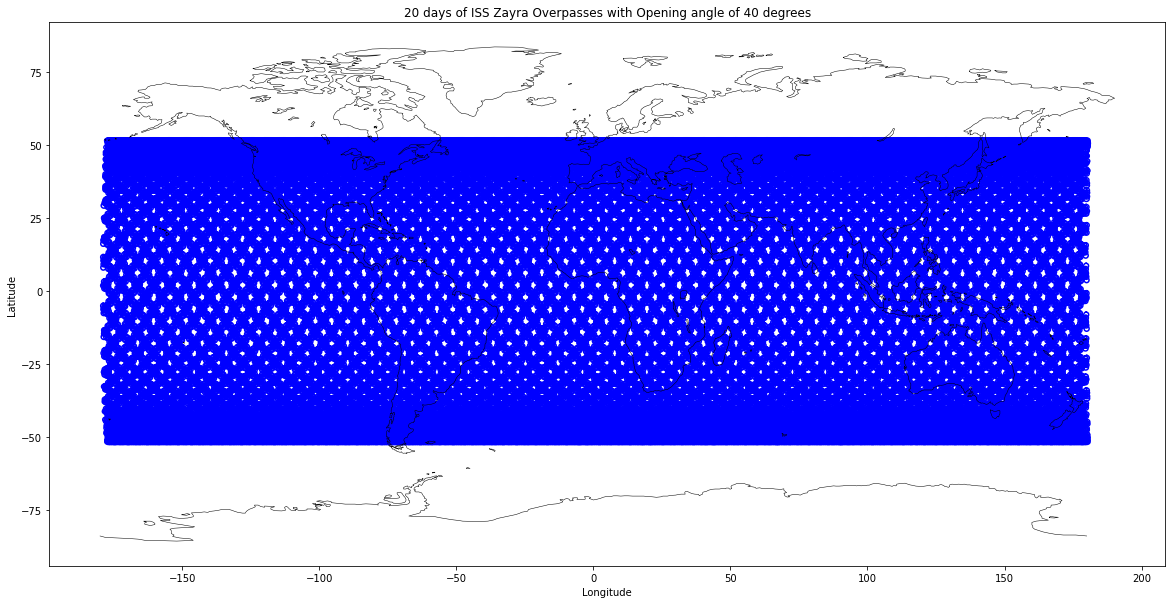

In [63]:
# manually plot the circles for 40
plt.figure(figsize=(20,10))
for l,d,theta in zip(lsatmask,dsatmask,theta40):
    
    sc_lat,sc_lon = scircle1(d,l,theta)
    plt.plot(sc_lon,sc_lat,color='b',)
    
    
plt.title(f'{numdays} days of ISS Zayra Overpasses with Opening angle of 40 degrees')
plt.plot(coast["long"], coast["lat"], color='black', linewidth=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")


## 2. Simulate and visualize the GPS satellite orbits

Simulate and visualize the GPS orbits. You may again use TLE from Celestrak. Deliverables for this sub-task are:

a.	Plot of the GPS ground tracks.  You may again use `pltgroundtracks` from the `tleplot` module. Please think carefully about how to plot this data in a nice and concise manner, as there are about 30 operational GPS satellites.


In [68]:
# enter here your code and run the cell to produce the result, if you wish you can use more cells
tle.tleget('GPS')
gpsERS = tle.tleread('GPS.txt',verbose=0)


Saving TLE set to default name
TLEGET: Downloaded gps-ops.txt from http://celestrak.com/NORAD/elements/
Saved TLE to GPS.txt


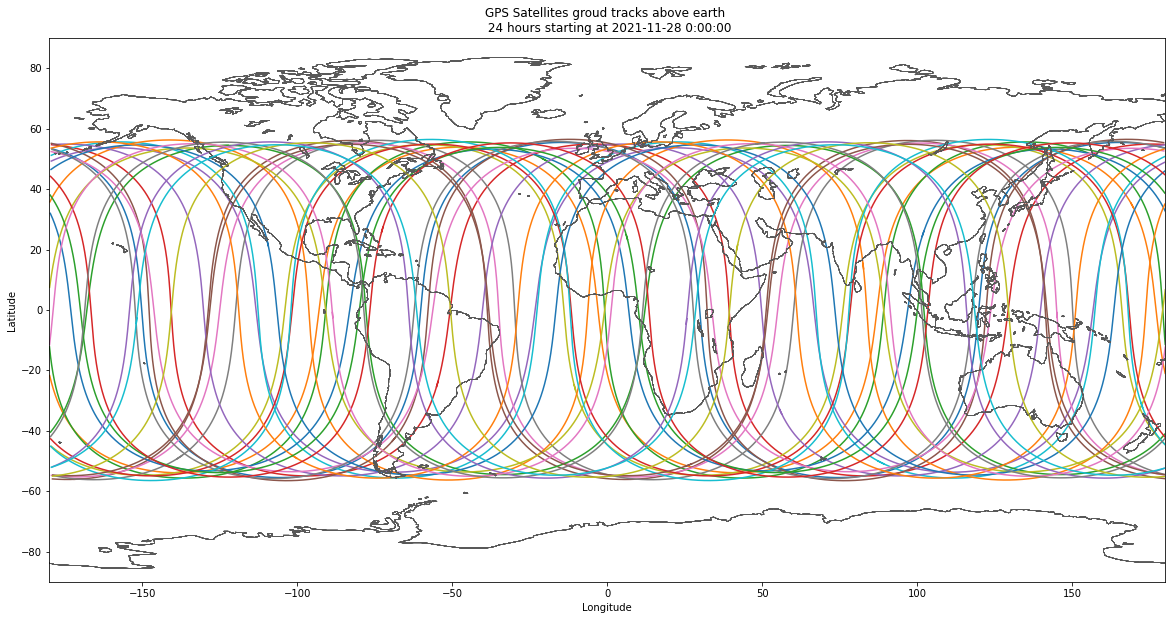

In [74]:
plt.figure(figsize=(20,10))
date = '2021-11-28 0:00:00'
plt.title(f'GPS Satellites groud tracks above earth \n 24 hours starting at {date}')
for sat in gpsERS:
    t = tle.tledatenum([date, 24*60 ,1])
    xsat,vsat = tle.tle2vec(gpsERS,t,sat.name)
    xsate,vsate = crs.eci2ecef(t,xsat=xsat,vsat=vsat)
    
    tle.pltgroundtrack(xsate)


b.	Polar plot (skyplot), using the azimuth and zenith angles, for a station on the Earth (e.g. Delft).  Hint: You may use the function `skyplot` from the `tleplot`  module. 


Delft ecef coordinate:  [10332497.84373162  8069310.22667264  5026823.69744795]
(3,)


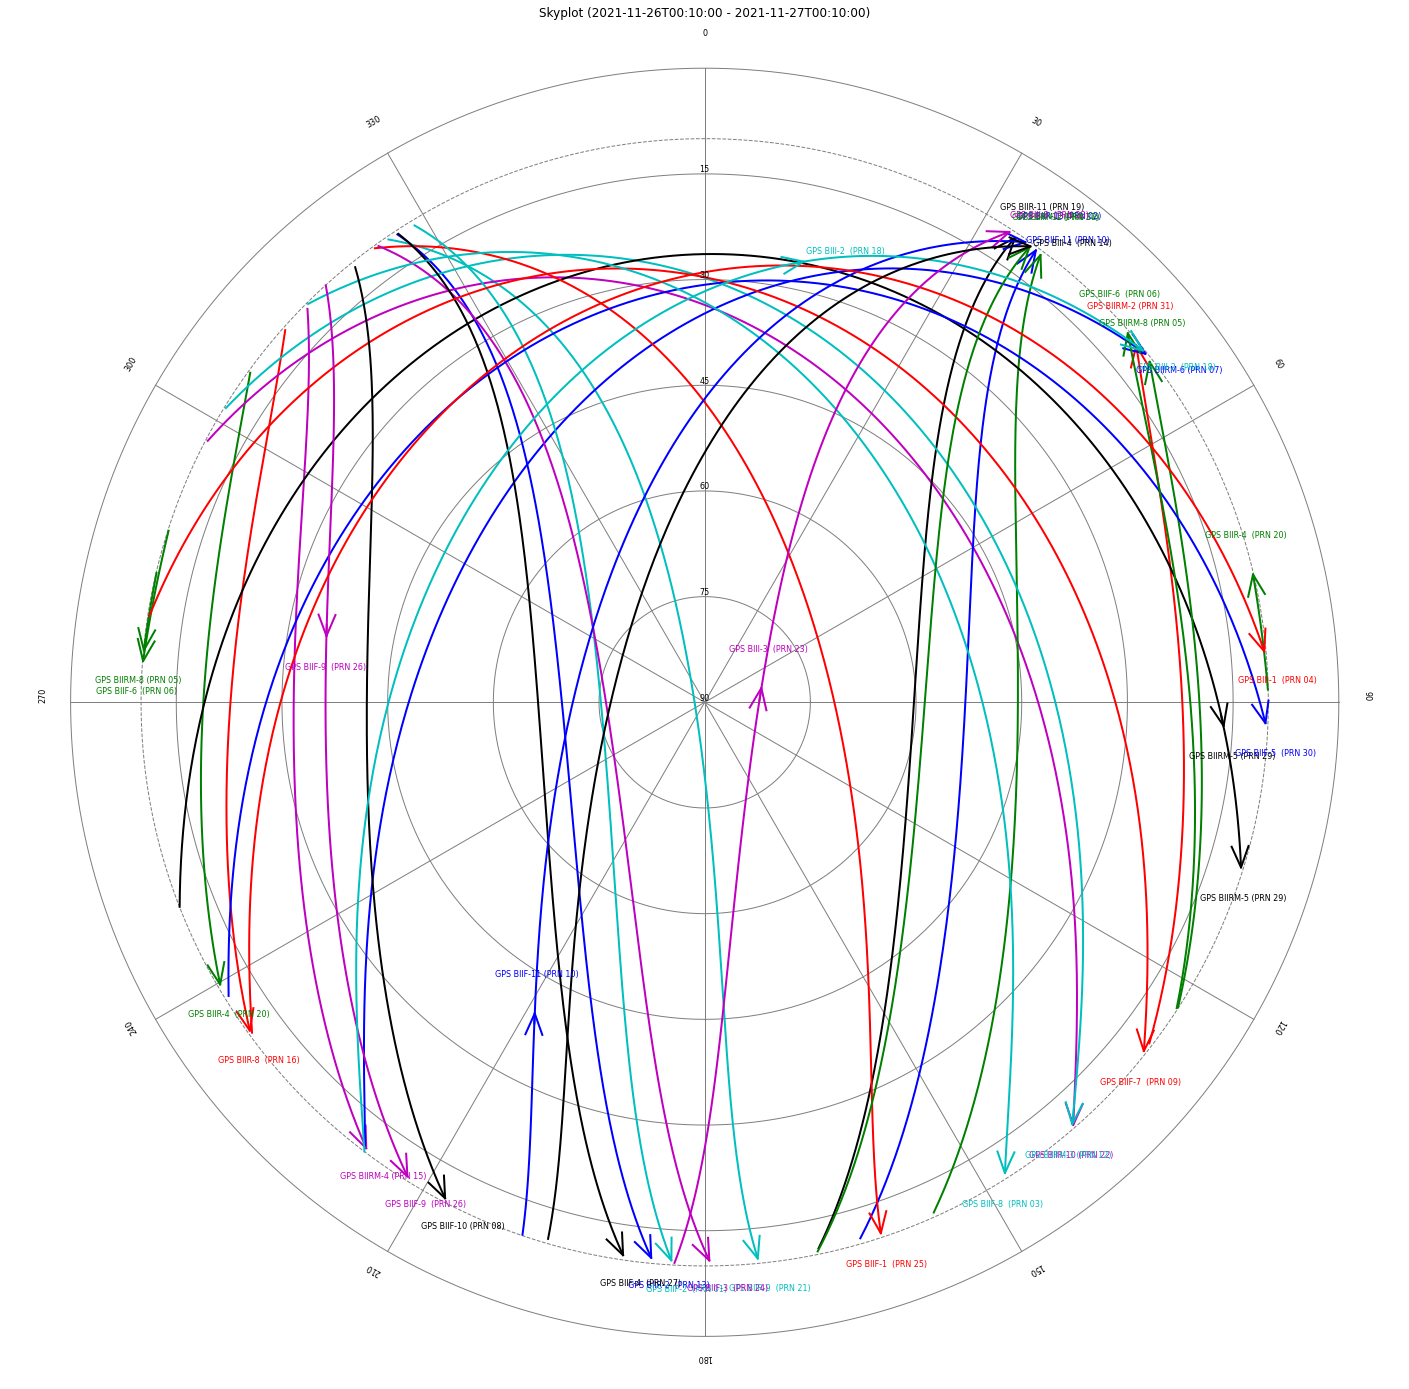

In [75]:
# to create a polar plot we need to define a location and find the look angles there
# we define a time array for this problem
date_q2b = '2021-11-26 0:10:00'
t = tle.tledatenum([date_q2b, 1*24*60, 1])

# use location of delft in radians
delft_lat_rad = np.deg2rad(4.358)
delft_lon_rad = np.deg2rad(52.01144)

# convert lat/long to ecef location
delft_ecef = Re*np.array(
    [
        np.cos(delft_lat_rad)/np.cos(delft_lon_rad),  # X
        np.cos(delft_lat_rad)/np.sin(delft_lon_rad),  # Y
        np.sin(delft_lon_rad),  # Z
    ]
)
# print the delft coorindates to check them
print('Delft ecef coordinate: ', delft_ecef)
print(delft_ecef.shape)

# set up a function to get the look angles from delft


def lookangle_from_delft(t, sat_data_ecef):
    lookangle, flags = crs.satlookanglesp(t, sat_data_ecef, delft_ecef,)
    return lookangle


plt.figure(figsize=(25, 25))
names = []

az_array = np.zeros((len(t), len(gpsERS)))
zen_array = np.zeros((len(t), len(gpsERS)))

for i, sat in enumerate(gpsERS):

    xsat, vsat = tle.tle2vec(gpsERS, t, sat.name)
    xsate, vsate = crs.eci2ecef(t, xsat=xsat, vsat=vsat)
    combined = np.concatenate((xsate, vsate), axis=1)
    las_array = lookangle_from_delft(t, combined)
    zen = las_array[:, 0]
    azi = las_array[:, 1]

    az_array[:, i] = azi
    zen_array[:, i] = zen
    names.append(sat.name)


tle.skyplot(t, az_array, zen_array, satnames=names,cutoff=10)




c.	Plot with the number of GPS satellite in view as function of time for the same ground station. Consider carefully how you define visibility and which value you use as elevation cut-off angle. Hint: As an intermediate step, create a 2D boolean array with an axis for satellite, and an axis for time, with True whenever a satellite is visible.

You may use a period of one day for these plots.

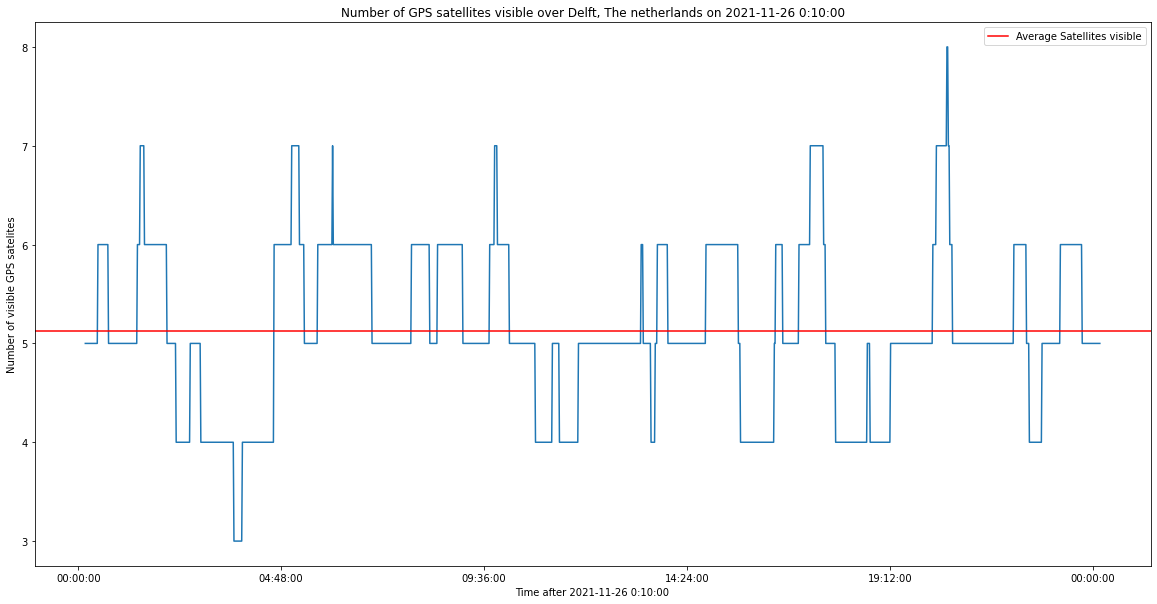

In [77]:
import matplotlib.dates as mdates

flags_array = np.zeros((len(t), len(gpsERS)))
for i, sat in enumerate(gpsERS):

    xsat, vsat = tle.tle2vec(gpsERS, t, sat.name)
    xsate, vsate = crs.eci2ecef(t, xsat=xsat, vsat=vsat)
    combined = np.concatenate((xsate, vsate), axis=1)
    a, flags = crs.satlookanglesp(t,
        combined,
        delft_ecef,
        swathdef=['VIS',0,80,''])

    # shows one if the satelite is visible
    flags_array[:, i] = flags[:, 2] == 'VIS'

visible_sats_delft = flags_array.sum(axis=1)

plt.figure(figsize=(20, 10))

plt.plot(t, visible_sats_delft)
date_form = mdates.DateFormatter("%H:%M:%S")
plt.xlabel(f'Time after {date_q2b}')
plt.ylabel('Number of visible GPS satelites')
plt.axhline(visible_sats_delft.mean(),color='r',label='Average Satellites visible')
plt.gca().xaxis.set_major_formatter(date_form)
plt.title(f'Number of GPS satellites visible over Delft, The netherlands on {date_q2b}')
plt.legend()

# save this variable for later use
delft_flags_array = flags_array

## 3. Simulate and visualize direct signals

Simulate and visualize GNSS signals from the **upward looking omnidirectional** antenna on the ISS (direct signals). The opening angle of the upward looking antenna is 160 degrees (comparable to a 10 degree elevation cut-off angle). For this sub-task you have to use the simulated ISS and GPS positions from the previous sub-tasks. Questions to answer are:

a.	How many GPS satellites are on average in view from the upward looking antenna? Illustrate this by a plot with the number of GPS satellite in view as function of time from the ISS (as in 2c). How does this compare to a station on the Earth (e.g. Delft)?


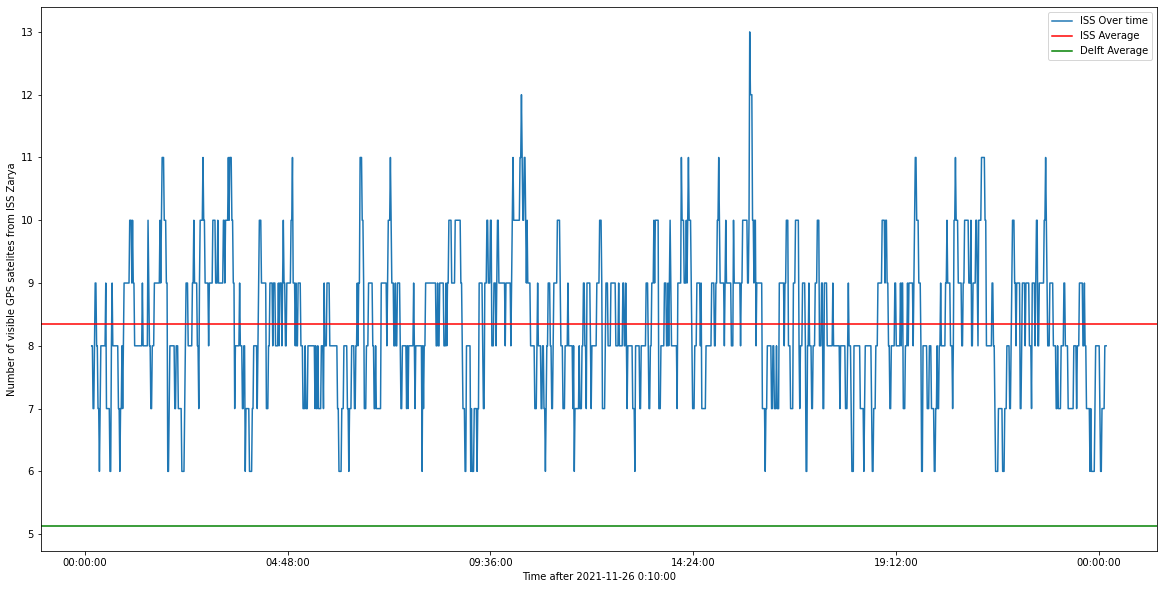

In [78]:
# setup the time for this cell
t = tle.tledatenum([date_q2b, 1*24*60, 1])

# combine the two output arrays into a single array and store them as a variable
iss_combined = np.concatenate(
    calculate_iss_ecef(t),
    axis=1
)

# create empty array to store the flags
flags_array = np.zeros((len(t),len(gpsERS)))
for i,sat in enumerate(gpsERS):
    xsat, vsat = tle.tle2vec(gpsERS, t, sat.name)
    xsate, vsate = crs.eci2ecef(t, xsat=xsat, vsat=vsat)
    sat_combined = np.concatenate((xsate, vsate), axis=1)
    lookangle, flags = crs.satlookanglesp(
        t,
        sat_combined,
        iss_combined,
        swathdef=['VIS', 0, 80, '']
    )
    
    # for each time step and satelite, it will show a 1 if visible and a 0 if not visible 
    flags_array[:,i] = flags[:, 2] == 'VIS'

visible_sats_iss = flags_array.sum(axis=1)

plt.figure(figsize=(20, 10))

plt.plot(t, visible_sats_iss,label='ISS Over time')
date_form = mdates.DateFormatter("%H:%M:%S")
plt.xlabel(f'Time after {date_q2b}')
plt.ylabel('Number of visible GPS satelites from ISS Zarya')
plt.gca().xaxis.set_major_formatter(date_form)
plt.axhline(visible_sats_iss.mean(),color='r',label='ISS Average')
plt.axhline(visible_sats_delft.mean(),color='g',label='Delft Average')
plt.legend()

# save for later use

iss_flags_array = flags_array


b.	What is the average duration of GPS satellite visibility, in minutes from start to end for each pass, from the ISS? Include a plot that clearly illustrates this answer. Again, how does this compare to the a station on the Earth?


In [14]:
def sat_duration(flgs):
    """
    takes in an array for flags where each row is a time step and each column is a different satellite
    """
    durations_list = []

    # loop over 
    for sat_visibility in flgs.T:
        # find where a change happens
        a = np.diff(sat_visibility)
        # find only select where a change occurs
        b = np.nonzero(a)
        # prepend a zero
        b = np.insert(b, 0, 0)
        # append the index of the last value
        b = np.append(b, np.array(len(flgs)))
        # b is the indexes where a change occurs
        c = np.diff(b)
        # now c contains *minutes* between changes. We need to select only the even values
        d = c[1::2]
        # flatten the values in d and them to the total list. This is required for satelites that have multiple passes within the time window
        for value in d:
            durations_list.append(value)

    return durations_list


(0.0, 1300.0)

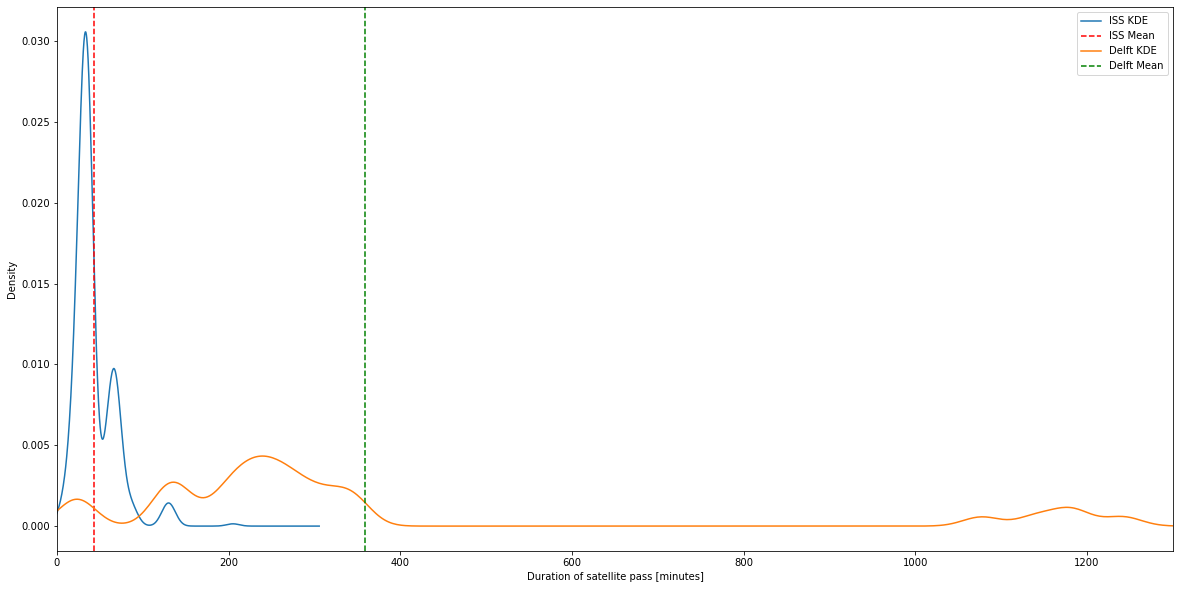

In [15]:
# taking advantage of convenient plotting syntax in pandas
from pandas import DataFrame

# create arrays of the duration values
iss_durations = np.array(sat_duration(iss_flags_array))
delft_durations = np.array(sat_duration(delft_flags_array))

# create the dataframes with named columns
df_iss = DataFrame(iss_durations,columns=['ISS KDE'])
df_delft = DataFrame(delft_durations,columns=['Delft KDE'])


# set up the plot that will be used
# to compare both the mean values and the distributions we will add the kernel density and the 
ax = df_iss.plot(kind='kde',figsize=(20,10),)

# add a vertical line to the plot
ax.axvline(iss_durations.mean(),color = 'r',label='ISS Mean',linestyle='--')

# plot the KDE on the same axis
df_delft.plot(kind='kde',bw_method=0.06,ax=ax)

# add a vertical line
ax.axvline(delft_durations.mean(),color='g',label='Delft Mean',linestyle='--')

# fixing plot styling issues
ax.legend()
ax.set_xlabel('Duration of satellite pass [minutes]')
ax.axes.set_xlim(0,1300)



c.	Visualize the ISS, GPS and observations from the upward looking omnidirectional antenna in Google Earth using the `simplekml` Python module. You may get some inspiration from exercise 6 `CIE4604-M2-Example6_kml.ipynb` notebook. Make separate kml folders (within the same kmz file) for ISS, GPS and direct observations. For the report (Jupyter notebook), include a screenshot showing trajectories for one day, but the direct observations only for a single epoch.

You may use a period of one day for the plots. 

In [16]:
def xyz2coords(x):
    """Compute list of (longitude, latitude, height) tuples from Cartesian coordinates.
    """
    lat, lon, height = xyz2llh(x)
    coords = llh2coords(lat, lon, height)
    
    return coords

def xyz2llh(x):
    """Compute latitude, longitude and height from Cartesian coordinates.

    lat, lon, height = xyz2llh(x) computes the spherical latitude [deg], longitude [deg],
    and height [m] from the array Cartesian coordinates X,Y,Z in x [m]. The cartesian 
    coordinates are given in an 2D numpy array x with X, Y and Z in the respective columns.
    """

    Re = 6378136

    if len(x.shape) == 1:
        R = np.sqrt(np.sum(x**2))
        lat = np.arcsin(x[2]/R) * 180/np.pi
        lon = np.arctan2(x[1], x[0]) * 180/np.pi
        height = R-Re
    else:
        R = np.sqrt(np.sum(x**2, axis=1))

        lat = np.arcsin(x[:,2]/R) * 180/np.pi
        lon = np.arctan2(x[:,1], x[:,0]) * 180/np.pi
        height = R-Re
    
    return lat, lon, height

def llh2coords(lat, lon, height):

    if type(lat) in [int, float]:
        lat = [lat]
        lon = [lon]
        height= [height]
        
    coords = []
    for k in range(len(lon)):
         coords.append((lon[k], lat[k], height[k]))
    
    return coords

In [17]:
import simplekml
# set a new t so it is consistant within this subquestion
t = tle.tledatenum(['2021-11-28 0:00:00', 24*60 ,1])

# get iss coordinates:
iss_xvalse,iss_vvalse = calculate_iss_ecef(t)

coords = xyz2coords(iss_xvalse)
kml = simplekml.Kml()
fol = kml.newfolder(name='ISS')
lin = fol.newlinestring(name="ISS", description="ISS track",
                        coords=coords)
lin.style.linestyle.color = simplekml.Color.darkolivegreen
lin.altitudemode = 'absolute'

gpsfol = kml.newfolder(name='GPS')
# loop over all the satelites and add each one to the kml file
for sat in gpsERS:
    # find the location in ECEF coords
    xsat,vsat = tle.tle2vec(gpsERS,t,sat.name)
    xsate,vsate = crs.eci2ecef(t,xsat=xsat,vsat=vsat)
    # find the lat, long coordinates for kml use
    coords = xyz2coords(xsate)

    # add the line string and set the parameters
    linsat = gpsfol.newlinestring(name = sat.name,coords=coords)
    linsat.style.linestyle.color = simplekml.Color.blue
    linsat.altitudemode = 'absolute'
    
###------------------------------------------###
# ADD THE LINE OF SIGHT
###------------------------------------------###

pathsfol = kml.newfolder(name='Line of Site')
# this variable selects the timestep that will be used
t_select = tle.tledatenum(['2021-11-28 0:00:00'])

# where is iss at this time step? we find it here
iss_xvalse,iss_vvalse = calculate_iss_ecef(t_select)

for sat in gpsERS:
    # find x location in ECEF for each satellite
    xsat,vsat = tle.tle2vec(gpsERS,t_select,sat.name)
    xsate,vsate = crs.eci2ecef(t_select,xsat=xsat,vsat=vsat)

    # find the iss position in ecef coords
    observer_position = iss_xvalse
    
    # add them together for use in satlookangesp function
    combined = np.concatenate((xsate,vsate),axis=1)

    # calculate the look angles array and the flags. We only need to use the flags
    lookangle,flags = crs.satlookanglesp(t_select,xsat=combined,xobj=observer_position,swathdef=['VIS', 0, 80, ''])

    # check the 'VIS' parameter, if it is there, then add the line to the kml
    if flags[0][2]=='VIS':
        # create a  ndarray of tuples in xyz coordinates for the line of sight between the ISS and the GPS sat
        iss_to_sat = np.concatenate((observer_position,xsat),axis=0)
        # convert the xyz coordinates to latlongs
        coords_LOS = xyz2coords(iss_to_sat)
        # create the kml line
        linview = pathsfol.newlinestring(name=sat.name,coords=coords_LOS)
        # set the color
        linview.style.linestyle.color = simplekml.Color.darkred
        # make sure the height displays correctly
        linview.altitudemode = 'absolute'
        

kml.save("iss.kml")    
kml.savekmz('A2.kmz')

## 4. Simulate and visualize reflected signals


Simulate and visualize GNSS signals from the **downward looking** antenna on the ISS (reflected signals). The opening angle of the downward looking antenna is 40 degrees or 100 degrees.

a.	Make a function to compute the position of  the specular reflection points that are within the field of view (opening angle) of the down looking GPS antenna on board the ISS at a specified moment in time. 

Input for this function is:  the position of the ISS and  GPS satellite positions at a specific time (one epoch only), and the opening angle of the downward looking antenna (40 or 100 degrees). The output should be the position of the specular reflection points (zero, one or more) that fall within the opening angle. For the actual computation you may call the function `specularpoint` from the `specularpoint.py` module that is part of the `CIE4604_M2_Python.zip` distribution. This is also explained in more detail in exercise 8 `CIE4604_M2_Example8_sp.ipynb` notebook.


In [18]:
def find_pts(t,gpssatxe, issxe, opening_angle=40):
    """
    accepts a tuple of positions of all 30 GPS satellits, a tuple of the station station position, and an opening angle

    returns a tuple of (angle,x,y,z) in cartesian coordinates

    """
    validspecularpts = []
    # loop over the satellites 
    for sat in gpssatxe:
        # calculate the look angles array and the flags. We only need to use the flags
        sat1 = (sat[:, None].T)
        # extract the visibility flags
        lookangle, flags = crs.satlookanglesp(t, xsat=sat1, xobj=issxe, swathdef=['VIS', 0, 80, ''])
        # check the 'VIS' parameter, if it is there,
        if flags[0][2] == 'VIS':
            transmit_sat_coord = sat1[0][:3]
            xp = sp.specularpoint(issxe[0], transmit_sat_coord)
            zrp, arp, _ = sp.xyz2zas(issxe[0], xp)
            nadir_to_pt = 180-zrp*180/np.pi
            # check the nadier is within the range
            if nadir_to_pt < opening_angle/2:
                # add specular point to list
                validspecularpts.append(xp)

    return validspecularpts



def locate_sat_iss_at_time(t):
    """
    takes a time, returns a tuple of the locations of all 30 satellites and the location of the iss
    """
    iss_xvalse,iss_vvalse = calculate_iss_ecef(t)
    satpos = np.zeros((len(gpsERS), 6))
    for i, sat in enumerate(gpsERS):
        xsat, vsat = tle.tle2vec(gpsERS, t, sat.name)
        xsate, vsate = crs.eci2ecef(t, xsat=xsat, vsat=vsat)
        iss_xvalse, iss_vvalse = calculate_iss_ecef(t)
        satpos[i] = np.concatenate((xsate, vsate), axis=1)

    return satpos,iss_xvalse

def find_pts_over_time(t_array,opening_angle=40):
    all_pts = []
    for t in t_array:
        # convert t to a valid date number
        a = crs.num2datetime(t)
        t = tle.tledatenum(a.isoformat())   
        satpos,iss_xvalse = locate_sat_iss_at_time(t)
        pts = find_pts(t,satpos,iss_xvalse,opening_angle)
        for pt in pts:
            all_pts.append(pt)

    return all_pts


b.	Make a plot with the specular reflection points, ISS and GPS ground tracks in Python for a period of several minutes for two different values of the opening angle.


Text(0.5, 1.0, 'Specular points for an opening angle of 40 degrees')

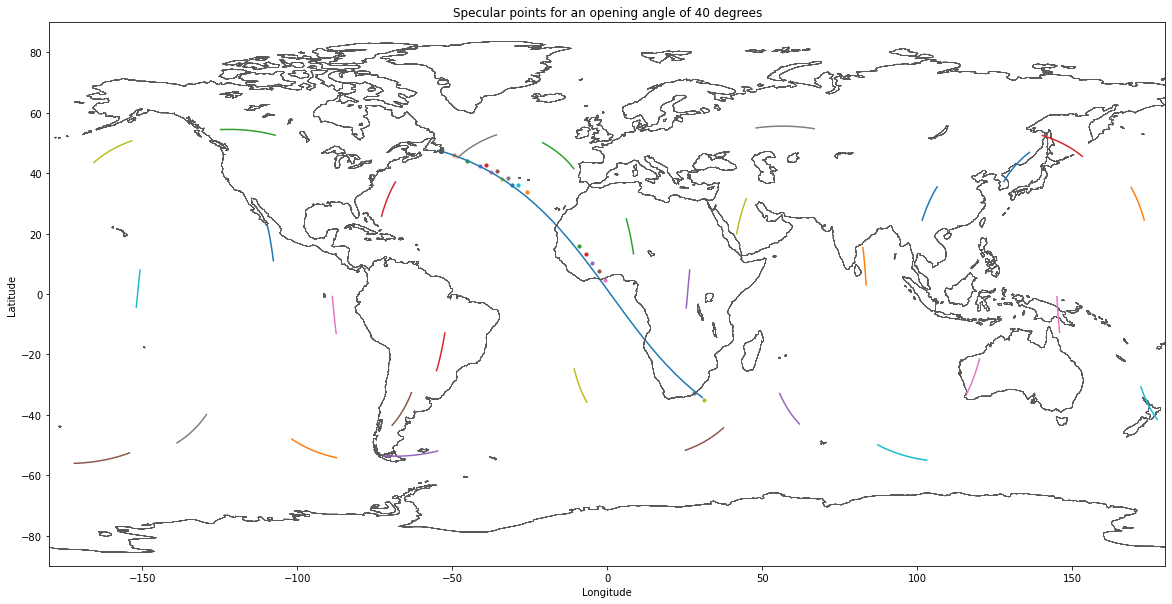

In [19]:
# define a time window for this problem 
timewindow = tle.tledatenum(['2021-11-28 0:00:00', 30 ,1])
# fine the specular points
specular_points = find_pts_over_time(timewindow)
# create a new figure
plt.figure(figsize=(20,10))
# get the ISS location during the problem time window
issxe,issve = calculate_iss_ecef(timewindow)
# add the iss
tle.pltgroundtrack(issxe)
# iterate over the points we found above and plot each one after converting to polar coordinates
for point in specular_points:
    stacked = np.vstack((point,point))
    tle.pltgroundtrack(stacked,linewidth=1)
    sphere = sp.cart2sphere(point)
    plt.scatter(sphere[1],sphere[0],s=10)
    
# add the satellites
for i, sat in enumerate(gpsERS):
    xsat, vsat = tle.tle2vec(gpsERS, timewindow, sat.name)
    xsate, vsate = crs.eci2ecef(timewindow, xsat=xsat, vsat=vsat)
    tle.pltgroundtrack(xsate,satid=sat.name)

plt.title('Specular points for an opening angle of 40 degrees')

Text(0.5, 1.0, 'Specular points for an opening angle of 40 degrees for a time window of 30 minutes')

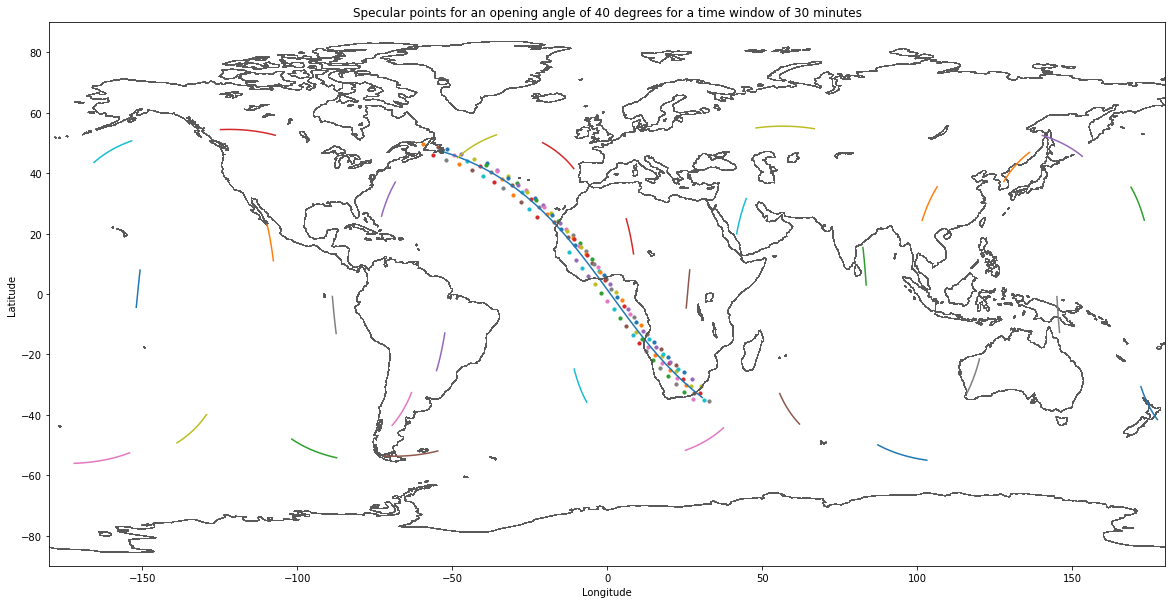

In [20]:
# define a time window for this problem 
timewindow = tle.tledatenum(['2021-11-28 0:00:00', 30 ,1])
# find the specular points
specular_points = find_pts_over_time(timewindow,opening_angle=100)
# create a new figure
plt.figure(figsize=(20,10))
# get the ISS location during the problem time window
issxe,issve = calculate_iss_ecef(timewindow)
# add the iss
tle.pltgroundtrack(issxe)
# iterate over the points we found above and plot each one after converting to polar coordinates
for point in specular_points:
    stacked = np.vstack((point,point))
    tle.pltgroundtrack(stacked,linewidth=1)
    sphere = sp.cart2sphere(point)
    plt.scatter(sphere[1],sphere[0],s=10)
    
# add the satellites
for i, sat in enumerate(gpsERS):
    xsat, vsat = tle.tle2vec(gpsERS, timewindow, sat.name)
    xsate, vsate = crs.eci2ecef(timewindow, xsat=xsat, vsat=vsat)
    tle.pltgroundtrack(xsate,satid=sat.name)

plt.title('Specular points for an opening angle of 40 degrees for a time window of 30 minutes')


c.	Visualize the specular reflection points and reflected signals in Google Earth for two different values of the opening angle (40 degrees and 100 degrees), and add this to the kmz file of question 3c. Make a new kml folder (within the same kmz file) for each opening angle. 

Include in your report a screenshot of Google Earth showing the ISS, GPS and specular reflection point trajectories for a period of several minutes, while showing the direct and reflected signals only for a single epoch.

In [21]:
# we modify the function to return the sat and iss locations
def find_sat_pts(t,gpssatxe, issxe, opening_angle=40):
    """
    accepts a tuple of positions of all 30 GPS satellits, a tuple of the station station position, and an opening angle

    returns a tuple of (x,y,z),satelite locaition, and iss location in cartesian coordinates

    """
    list_of_sats_iss_pts = []
    # loop over the satellites 
    for sat in gpssatxe:
        # calculate the look angles array and the flags. We only need to use the flags
        sat1 = (sat[:, None].T)
        # extract the visibility flags
        lookangle, flags = crs.satlookanglesp(t, xsat=sat1, xobj=issxe, swathdef=['VIS', 0, 80, ''])
        # check the 'VIS' parameter, if it is there,
        if flags[0][2] == 'VIS':
            transmit_sat_coord = sat1[0][:3]
            xp = sp.specularpoint(issxe[0], transmit_sat_coord)
            zrp, arp, _ = sp.xyz2zas(issxe[0], xp)
            nadir_to_pt = 180-zrp*180/np.pi
            # check the nadier is within the range
            if nadir_to_pt < opening_angle/2:
                # add specular point to list
                list_of_sats_iss_pts.append([sat1,issxe,xp])
    return list_of_sats_iss_pts

def locate_sat_iss_at_time(t):
    """
    takes a time, returns a tuple of the locations of all 30 satellites and the location of the iss
    """
    iss_xvalse,iss_vvalse = calculate_iss_ecef(t)
    satpos = np.zeros((len(gpsERS), 6))
    for i, sat in enumerate(gpsERS):
        xsat, vsat = tle.tle2vec(gpsERS, t, sat.name)
        xsate, vsate = crs.eci2ecef(t, xsat=xsat, vsat=vsat)
        iss_xvalse, iss_vvalse = calculate_iss_ecef(t)
        satpos[i] = np.concatenate((xsate, vsate), axis=1)

    return satpos,iss_xvalse

def find_pts_over_time2(t_array,opening_angle=40):
    all_pts = []
    for t in t_array:
        # convert t to a valid date number
        a = crs.num2datetime(t)
        t = tle.tledatenum(a.isoformat())   
        satpos,iss_xvalse = locate_sat_iss_at_time(t)
        pts = find_sat_pts(t,satpos,iss_xvalse,opening_angle)
        for pt in pts:
            all_pts.append(pt)

    return all_pts

timewindow = tle.tledatenum(['2021-11-28 0:00:00', 30 ,1])

sats = find_pts_over_time2(timewindow)

specular_folder40 = kml.newfolder(name='Specular Points 40 degree')

for s in sats:
    sat = s[0][0][:3]
    iss = s[1][0]
    xp = s[2]

    cartesian_coords = np.vstack((sat,xp,iss))
    coords = xyz2coords(cartesian_coords)
    speclin40 = specular_folder40.newlinestring(name='40 degree opening angle',coords=coords)
    speclin40.linestyle.color = simplekml.Color.crimson
    speclin40.altitudemode = 'absolute'

sats = find_pts_over_time2(timewindow,opening_angle=100)

specular_folder100 = kml.newfolder(name='Specular Points 100 degree')

for s in sats:
    sat = s[0][0][:3]
    iss = s[1][0]
    xp = s[2]

    cartesian_coords = np.vstack((sat,xp,iss))
    coords = xyz2coords(cartesian_coords)
    speclin100 = specular_folder100.newlinestring(name='40 degree opening angle',coords=coords)
    speclin100.linestyle.color = simplekml.Color.gold
    speclin100.altitudemode = 'absolute'


kml.save("iss.kml")    
kml.savekmz('A2.kmz')

# Deliverables

The deliverables for this assignment are 

1.	Pdf of your Jupyter notebook or short report (pdf)  with a description of the GNSS-R simulator, plots of the results and answers to the questions.
2.	KMZ file (for display in Google Earth), one kmz file only, for question 3c and 4c combined.
3.	Jupyter notebook or zip file with the code.

The above deliverables have to be submitted electronically  through Brightspace.


[End of this Jupyter notebook]